# Importing Libraries

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageFilter
figure_size = 9 # the dimension of the x and y axis of the kernal.a
from skimage.util import random_noise
from google.colab.patches import cv2_imshow
from multiprocessing import Pool
import os
import sys
import math

# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Generating Frames from Video

In [ ]:
import cv2
import os
path = '/content/drive/My Drive/Research Papers/Frames'
vidcap = cv2.VideoCapture('/content/drive/My Drive/Research Papers/video1.mp4')
try: 
      
    # creating a folder named data 
    if not os.path.exists('data'): 
        os.makedirs('data') 
  
# if not created then raise error 
except OSError: 
    print ('Error: Creating directory of data') 

def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    if hasFrames:
        cv2.imwrite(os.path.join(path ,"image"+str(count)+".png"), image)     # save frame as JPG file
    return hasFrames

sec = 0
frameRate = 0.5 #//it will capture image in each 0.5 second
count=1
success = getFrame(sec)


while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)

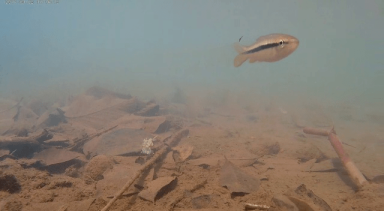

In [ ]:
image = cv2.imread("/content/drive/My Drive/Research Papers/Frames/image11png.png")

scale_percent = 60 # percent of original size
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
cv2_imshow(image)

## Guassian noise

In [ ]:
def convolution(oldimage, kernel):
    #image = Image.fromarray(image, 'RGB')
    image_h = oldimage.shape[0]
    image_w = oldimage.shape[1]
    
    
    kernel_h = kernel.shape[0]
    kernel_w = kernel.shape[1]
    
    if(len(oldimage.shape) == 3):
        image_pad = np.pad(oldimage, pad_width=((kernel_h // 2, kernel_h // 2),(kernel_w // 2,kernel_w // 2),(0,0)), mode='constant',constant_values=0).astype(np.float32)  
            
            
            
    elif(len(oldimage.shape) == 2):
        image_pad = np.pad(oldimage, pad_width=((kernel_h // 2, kernel_h // 2),(kernel_w // 2,kernel_w // 2)), mode='constant', constant_values=0).astype(np.float32) 
            
            
    
    h = kernel_h // 2
    w = kernel_w // 2
    
    image_conv = np.zeros(image_pad.shape)
    
    for i in range(h, image_pad.shape[0]-h):
        for j in range(w, image_pad.shape[1]-w):
            #sum = 0
            x = image_pad[i-h:i-h+kernel_h, j-w:j-w+kernel_w]
            x = x.flatten()*kernel.flatten()
            image_conv[i][j] = x.sum()
    h_end = -h
    w_end = -w
    
    if(h == 0):
        return image_conv[h:,w:w_end]
    if(w == 0):
        return image_conv[h:h_end,w:]
    return image_conv[h:h_end,w:w_end]

In [ ]:
def GaussianBlurImage(image, sigma):
    # image = imread(image)
    # image = Image.open(image)
    # image = np.asarray(image)
    #print(image)
    if(sigma<1):
      sigma = 1  
      
      
    filter_size = 2 * int(4 * sigma + 0.5) + 1
    gaussian_filter = np.zeros((filter_size, filter_size), np.float32)
    m = filter_size//2
    n = filter_size//2
    
    for x in range(-m, m+1):
        for y in range(-n, n+1):
            x1 = 2*np.pi*(sigma**2)
            x2 = np.exp(-(x**2 + y**2)/(2* sigma**2))
            gaussian_filter[x+m, y+n] = (1/x1)*x2
  
    
    im_filtered = np.zeros_like(image, dtype=np.float32)
    for c in range(3):
        im_filtered[:,:,c] = convolution(image[:,:,c], gaussian_filter)
    return (im_filtered.astype(np.uint8))

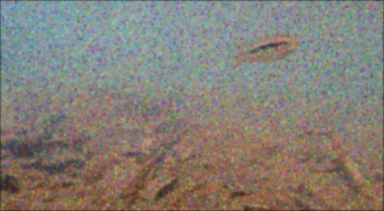

In [ ]:
image_guas=GaussianBlurImage(noise_img, 0.5)
path = '/content/drive/My Drive/Research Papers/Frames'
cv2.imwrite(os.path.join(path ,"image11_noise_blur.png"), image_guas) 
cv2_imshow(image_guas)

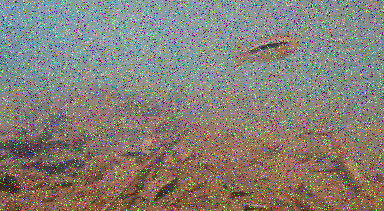

True

In [ ]:
noise_img = random_noise(image, mode='s&p',amount=0.1)

# The above function returns a floating-point image
# on the range [0, 1], thus we changed it to 'uint8'
# and from [0,255]
noise_img = np.array(255*noise_img, dtype = 'uint8')

# Display the noise image
cv2_imshow(noise_img)
path = '/content/drive/My Drive/Research Papers/Frames'
cv2.imwrite(os.path.join(path ,"image11_noise.png"), noise_img) 

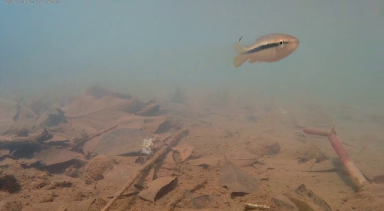


# Bilateral Filter

In [ ]:
q=[]
def gaussian_range(x,sigma):
  summ=0;
  for i in range(-x,x+1):
    if(i==0):
      continue
    else:
      gamma = np.pi*(x/2)
      rho = gamma*sigma
      x2 = np.exp(-((gamma**2)*(i**2))/(2*(rho**2)))
      summ+=x2
  # q.append(summ)
  if(summ==0):
    return 11.310170772882662
  else:
    return summ

def distance(x, y, i, j):
    return np.sqrt((x-i)**2 + (y-j)**2)


def gaussian(x, sigma):
    return (1.0 / (2 * math.pi * (sigma ** 2))) * math.exp(- (x ** 2) / (2 * sigma ** 2))

def apply_bilateral_filter(source, filtered_image, x, y, diameter, sigma_i, sigma_s):
    hl = diameter//2
    i_filtered = 0
    xi = 0
    Wp = 0
    i = 0
    while i < diameter:
        j = 0
        while j < diameter:
            neighbour_x = x - (hl - i)
            neighbour_y = y - (hl - j)
            if neighbour_x >= len(source):
                neighbour_x -= len(source)
            if neighbour_y >= len(source[0]):
                neighbour_y -= len(source[0])
            diff_intensity = source[neighbour_x][neighbour_y] - source[x][y]
            xi = diff_intensity[0]
            
            gi = gaussian_range(xi, sigma_i)
            
            gs = gaussian(distance(neighbour_x, neighbour_y, x, y), sigma_s)
            w = gi * gs
            i_filtered += source[neighbour_x][neighbour_y] * w
            Wp += w
            j += 1
        i += 1
    i_filtered = i_filtered // Wp
    filtered_image[x][y] = i_filtered.round()

def bilateral_filter_own(source, filter_diameter, sigma_i, sigma_s):
    filtered_image = np.zeros(source.shape)
    aswathy=0
    i = 0
    while i < len(source):
        j = 0
        while j < len(source[0]):
            apply_bilateral_filter(source, filtered_image, i, j, filter_diameter, sigma_i, sigma_s)
            j += 1
            aswathy += 1
            
            print(aswathy)
        i += 1
    return filtered_image

In [ ]:
image.shape
#image = cv2.imread("/content/drive/My Drive/Research Papers/Frames/image11.jpg")
#cv2_imshow(image)

(211, 384, 3)

In [ ]:
filtered_image_own = bilateral_filter_own(image_guas, 7, 12.0, 16.0)
path = '/content/drive/My Drive/Research Papers/Frames'
cv2.imwrite(os.path.join(path ,"groundimage11_reconstructed.png"),filtered_image_own ) 

In [ ]:
cv2_imshow(np.hstack((image, filtered_image_own)))
cv2_imshow(np.hstack((noise_img, filtered_image_own)))

# CLAHE

In [ ]:
def increase_contrast(image):
    """Uses CLAHE (Contrast Limited Adaptive Histogram Equalization) to increase
    the contrast of an image. Found on Stack Overflow, written by Jeru Luke."""
    img = np.array(image, dtype=np.uint8)

    # Converting image to LAB Color model
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    # Splitting the LAB image to different channels
    l, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel---
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    # Merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl, a, b))

    # Converting image from LAB Color model to RGB model
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    return final 

In [ ]:
#cv2_imshow(image)
#cv2_imshow(filtered_image_own)
#cv2_imshow(np.hstack((noise_img,image_guas,image_clahe)))
g = increase_contrast(filtered_image_own)
path = '/content/drive/My Drive/Research Papers/Frames'
cv2.imwrite(os.path.join(path ,"groundimage11_reconstructed_clahe.png"),g ) 

True

# Main Code

In [ ]:
path1 = "/content/drive/My Drive/Research Papers/Frames"
path2 = "/content/drive/My Drive/Research Papers/Filtered Frames"
count=9
import glob
from PIL import Image


images=glob.glob("/content/drive/My Drive/Research Papers/Frames/*.jpg")
for img in images:    
    image =cv2.imread(img)
    # img.show()
    scale_percent = 60 # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)

    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

    filtered_image_own = bilateral_filter_own(resized, 5, 12.0, 16.0)

    g = increase_contrast(filtered_image_own)

    count = count + 1
    cv2.imwrite(os.path.join(path2 ,"image"+str(count)+".jpg"), g)  
    print("image"+str(count)+".jpg saved")

image10.jpg saved


## Frames to Video

In [ ]:
import cv2
import numpy as np
import os
from os.path import isfile, join
pathIn= '/content/drive/My Drive/Research Papers/Filtered Frames/'
pathOut = '/content/drive/My Drive/Research Papers/trial/video1.avi'
fps = 2
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: x[5:-4])
files.sort()
frame_array = []
files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
#for sorting the file names properly
files.sort(key = lambda x: x[5:-4])
for i in range(len(files)):
    filename=pathIn + files[i]
    #reading each files
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)
out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()

## SNR

For computing SNR for one image

In [ ]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [ ]:
image = cv2.imread('/content/drive/My Drive/Research Papers/Frames/blurimage11_reconstructed_clahe.png')
snr = signaltonoise(image, axis=None)
print(snr)

4.651273491109983


For comparing SNR of 2 images

In [ ]:
import numpy 
import math
import cv2
original = cv2.imread("/content/drive/My Drive/Research Papers/Frames/groundimage_reconstructed_clahe.png")
contrast = cv2.imread("/content/drive/My Drive/Research Papers/Frames/image11.jpg")

def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
      return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [ ]:
img1 = cv2.imread("/content/drive/My Drive/Research Papers/Frames/groundimage_reconstructed_clahe.png")
img2 = cv2.imread("/content/drive/My Drive/Research Papers/Frames/image11.png")
# psnr(img1,img2)

TypeError: ignored

2nd way

In [ ]:
import cv2 
img1 = cv2.imread('/content/drive/My Drive/Research Papers/Frames/images/image_noise (1).png')
img2 = cv2.imread('/content/drive/My Drive/Research Papers/Frames/images/groundimage11_reconstructed_clahe.png')
# psnr = cv2.PSNR(img1, img2)
# print(psnr)

In [ ]:
def mse(vref, vcmp):
    """
    Compute Mean Squared Error (MSE) between two images.
    Parameters
    ----------
    vref : array_like
      Reference image
    vcmp : array_like
      Comparison image
    Returns
    -------
    x : float
      MSE between vref and vcmp
    """

    r = np.asarray(vref, dtype=np.float64).ravel()
    c = np.asarray(vcmp, dtype=np.float64).ravel()
    return np.mean(np.abs(r - c)**2)



def snr(vref, vcmp):
    """
    Compute Signal to Noise Ratio (SNR) of two images.
    Parameters
    ----------
    vref : array_like
      Reference image
    vcmp : array_like
      Comparison image
    Returns
    -------
    x : float
      SNR of vcmp with respect to vref
    """

    dv = np.var(vref)
    with np.errstate(divide='ignore'):
        rt = dv / mse(vref, vcmp)
    return 10.0 * np.log10(rt)

In [ ]:
a = mse(img1, img2)

In [ ]:
img1.shape

(352, 640, 3)

In [ ]:
img2.shape

(1408, 2560, 3)

In [ ]:
print(a)

2141.3371922722486


In [ ]:
snr(img1,img2)

0.16563924193308074